### Soil water balance module
Based on: Global land-surface evaporation estimated from satellite-based
observations

In [8]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


### Input data

In [9]:
#calculate PET from  data in data_processing.py
#source directory
src=r"W:\VUB\_main_research\scripts\wetland_model\conceptual_model\data"

pET_k = 0.408 * (delta/(delta + gamma)) * net_radiation
precip=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
precip.index=pd.to_datetime(precip.index, format='%d/%m/%Y')

#surface soil moisture data extracted from SMAP
smap_ssm=pd.read_excel(src+"/smap_surface_sm_boechout_9km.xlsx", index_col=0)
smap_ssm.index=pd.to_datetime(smap_ssm.index) 

### Parameters

In [10]:
alpha_tall_canopy = 0.8
alpha_short_canopy = 1.26 #short veg. and bare soil
beta = 0.07
s_fc = 0.5
s_wp = 0.1
LAI = 3.5

### Initialize variable arrays

In [11]:
# Number of time steps
n_steps = len(precip)

# Pre-allocate arrays with zeros
interception = np.zeros(n_steps)  # Interception array
infil = np.zeros(n_steps)         # Infiltration array
perco = np.zeros(n_steps)         # Percolation array
sm = np.zeros(n_steps) 
E_stress_tc = np.zeros(n_steps) # Evaporation stress tall canopy
E_stress_sc = np.zeros(n_steps) # Evaporation stress short canopy
E_stress_bs = np.zeros(n_steps) # Evaporation stress
evap_actual_tc = np.zeros(n_steps)
evap_actual_sc = np.zeros(n_steps)
evap_actual_bs = np.zeros(n_steps)
total_evap = np.zeros(n_steps)


# Initial conditions
sm[0] = s_fc  # Initial soil moisture is at field capacity
E_stress_tc[0] = 1  # Initial evaporation stress is 1
E_stress_sc[0] = 1  
E_stress_bs[0] = 1  
infil[0] = 0.5 * s_fc  # max infiltration at the start
perco[0] = 0  # No percolation at the start
total_evap[0] = 0
evap_actual_tc[0] =  0.5
evap_actual_sc[0] =  0.5
evap_actual_bs[0] =  0.5
interception[0] = 0.1  #
soil_depth = 300  # mm

frac_tall_canopy = 0.5
frac_short_canopy = 0.3
frac_bare_soil = 0.2
tau = 0.8 #or 0.2 a parameter accounting for the development of vegetation over the year (vegetation optical depth).

### Soil moisture simulation

In [12]:
dt = 1  # Time step in days

# Loop through time steps
for time in range(1, n_steps - 1):
    # Step 1: Calculate interception
    interception[time] = min(precip['precipitation'].iloc[time], 0.05 * LAI)

    # Step 2: Calculate infiltration
    infil[time] = max(0, precip['precipitation'].iloc[time] - interception[time])

    #calculate evaporation stress for tall canopy
    E_stress_tc[time] = 1 - ((s_fc - sm[time - 1]) / (s_fc - s_wp))**2
    E_stress_sc[time] = 0.5*(1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp)) + tau/0.8)
    E_stress_bs[time] = 1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp))

    #calculate actual evaporation from all vegetation classes, including bare areas
    evap_actual_tc[time] = pET_k.iloc[time] * E_stress_tc[time] * frac_tall_canopy * alpha_tall_canopy
    evap_actual_sc[time] = pET_k.iloc[time] * E_stress_sc[time] * frac_short_canopy * alpha_short_canopy
    evap_actual_bs[time] = pET_k.iloc[time] * E_stress_bs[time] * frac_bare_soil * alpha_short_canopy

    # Step 4: Calculate total evapotranspiration (including interception)
    total_evap_unconstrained = (
        evap_actual_tc[time] +
        evap_actual_sc[time] +
        evap_actual_bs[time] +
        interception[time]
    )

    # Step 5: Ensure total ET does not exceed PET
    if total_evap_unconstrained > pET_k.iloc[time]:
        # Scale components proportionally
        scaling_factor = pET_k.iloc[time] / total_evap_unconstrained
        evap_actual_tc[time] *= scaling_factor
        evap_actual_sc[time] *= scaling_factor
        evap_actual_bs[time] *= scaling_factor
        interception[time] *= scaling_factor

    # Recalculate total ET after scaling
    total_evap[time] = (
        evap_actual_tc[time] +
        evap_actual_sc[time] +
        evap_actual_bs[time] +
        interception[time]
    )

    # Step 3: Update soil moisture (before percolation)
    sm[time] = sm[time - 1] + (infil[time] - total_evap[time -1]) / soil_depth

    # Step 4: Handle percolation if soil moisture exceeds field capacity
    if sm[time] > s_fc:
        perco[time] = sm[time] - s_fc  # Excess water becomes percolation
        sm[time] = s_fc  # Soil moisture is capped at field capacity
    else:
        perco[time] = 0  # No percolation if below field capacity

    # Step 5: Enforce lower boundary for soil moisture
    sm[time] = max(0, sm[time])  # Prevent negative soil moisture

#### Transform arrays to dataframes

In [13]:
#convert arrays to pandas series
model_arrays = [interception, infil, perco, sm, evap_actual_tc, evap_actual_sc, evap_actual_bs, total_evap]
array_names = ['Interception', 'Infiltration', 'Percolation', 'Soil Moisture', 'Evap tall canopy', 'Evap short canopy', 'Evap bare soil', 'Total Evapotranspiration']
model_df = pd.DataFrame(model_arrays, index=array_names).T
model_df.index = pET_k.index

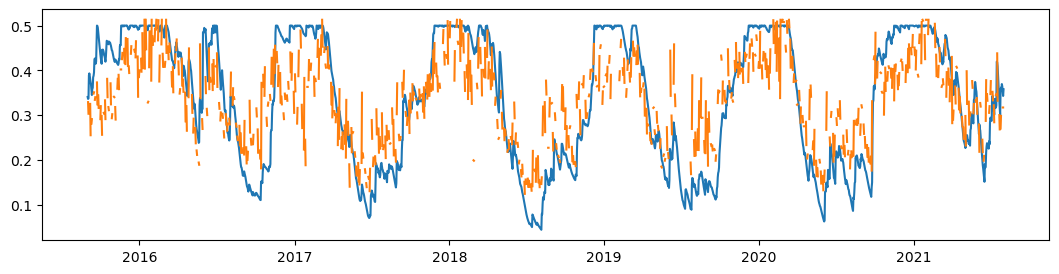

In [14]:
start_date='2015-09-01'
end_date='2021-07-31'

fig,ax=plt.subplots(figsize=(13,3))
#plt.plot(500*perco[200:4800])
#plt.plot(E_stress_bs)[200:-1]
plt.plot(model_df['Soil Moisture'][start_date:end_date])
plt.plot(smap_ssm['soil_moisture_am'][start_date:end_date])

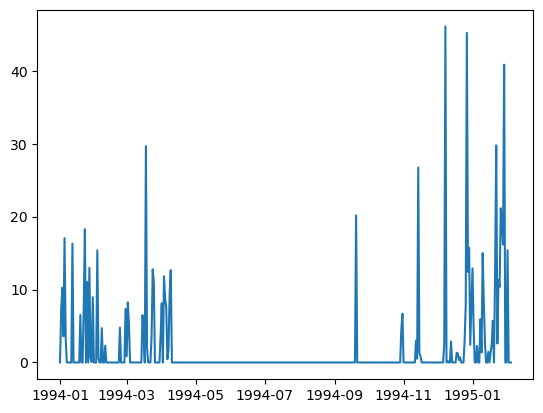

In [19]:
plt.plot((500*model_df['Percolation'][0:400]))

<Axes: xlabel='time'>

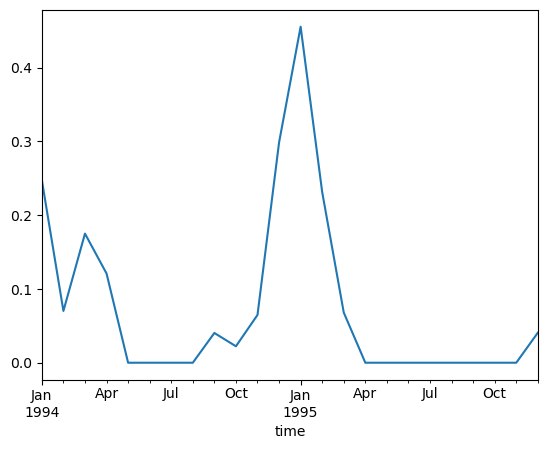

In [28]:
perco_mon = model_df['Percolation'].resample('ME').sum()
perco_mon[0:24].plot()